오토인코더 만들기.

1. Dataset
    - CIFAR-10
2. 이미지를 8x8 혹은 4x4 블록으로 쪼개서 DCT 변환 후, DCT Coeff를 Output으로 내는 AutoEncoder.
3. 모델의 Output을 IDCT 해서 원래 이미지가 잘 나오는 지 확인

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # 물리적 순서대로 정렬
os.environ["CUDA_VISIBLE_DEVICES"] = "6"        # 나는 6번 GPU만 보이게 하겠다!

import torch
print(f"현재 사용 가능한 GPU 개수: {torch.cuda.device_count()}")
print(f"현재 선택된 GPU 번호: {torch.cuda.current_device()}")
print(f"장치 이름: {torch.cuda.get_device_name(0)}")

현재 사용 가능한 GPU 개수: 1
현재 선택된 GPU 번호: 0
장치 이름: NVIDIA GeForce RTX 3090


In [ ]:
# 흑백으로 출력함. 
# dct_ae_cifar10.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# -----------------------------
# 1. DCT / IDCT utilities -> 데이터를 DCT 영역과 이미지 영역을 넘나들 수 있게 함.
# -----------------------------

def dct2(block):
    # 2D DCT (orthonormal)
    return dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
    # ㄴ DCT를 하면서, block은 8*8 이고, axis가 0이면 DCT의 C행렬이 왼쪽에 붙고, axis가 1이면 오른쪽(이건 C의 전치)에 붙는다. 
    # norm='ortho'는 C전치C가 항등행렬임을 정의한다. 정규화 과정이다.
    # block 안에는 그냥 8*8 데이터 저장소일뿐, DCT 되기 전 데이터가 있을수도 있고, 그 후의 데이터가 있을 수도 있다. 
def idct2(block):
    # 2D IDCT (orthonormal)
    return idct(idct(block, axis=0, norm='ortho'), axis=1, norm='ortho')

def image_to_dct_blocks(img, block_size=8): # 블록을 8*8로 쪼개기. 
    """
    img: (H, W) numpy array -> 높이, 너비. 32*32 흑백 이미지
    return: (num_blocks, block_size*block_size) -> (16, 64)
    """
    H, W = img.shape
    blocks = [] # 8*8 블록 하나를 DCT 한 뒤, 1차원 64개로 플랫튼. 
    for i in range(0, H, block_size): # 0 8 16 24
        for j in range(0, W, block_size):
            block = img[i:i+block_size, j:j+block_size]
            blocks.append(dct2(block).flatten()) # 블록 하나를 행이 큰단위, 열이 작은단위로 64개 원소 폄. 그걸 리스트의 한 원소로 추가
    return np.stack(blocks) # (16, 64). 16개의 블록 펼쳐진게 쌓여있음. 리스트의 각 원소를 한 행으로 쌓음. 
                            # 사실 위랑 구조는 같은데, 연산 가능한 행렬로 바꾼 것임. 16행 64열 행렬. 

# 그냥 위의 역 과정임.
def dct_blocks_to_image(blocks, H, W, block_size=8):
    """
    blocks: (num_blocks, block_size*block_size)
    return: reconstructed image (H, W)
    """
    img = np.zeros((H, W))
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = blocks[idx].reshape(block_size, block_size)
            img[i:i+block_size, j:j+block_size] = idct2(block)
            idx += 1
    return img

# -----------------------------
# 2. AutoEncoder definition
# -----------------------------

class DCTAutoEncoder(nn.Module): # 블록간 간섭 없고, 완전히 독립적으로 압축, 복원. 64개 들어가서 64개 나옴.
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), #정보가 강제로 사라졌다가 다시 추청한거라, 기존의 32차원의 정보를 완벽히 복원할 수 없음!!! *중요*
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# -----------------------------
# 3. Dataset (CIFAR-10) -> 컬러 이미지 50,000장을 흑백으로 바꾸고, 연산하기 쉽게 변환. 
# -----------------------------

transform = transforms.Compose([
    transforms.Grayscale(),  # 단순화를 위해 grayscale. 처리하면 RGB가 흑백사진으로 바뀜. 현재 코드는 컬러로 복원하지 않음.
    transforms.ToTensor() # (1, 32, 32)로 변경되고, float32 [0, 1] 범위로 바뀜. 원래는 unit8 [0, 255] 임. 
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True
)

# -----------------------------
# 4. Training setup
# -----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DCTAutoEncoder().to(device)
criterion = nn.MSELoss() # 기준은 Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=1e-3) # 인코더 디코더의 모든 파라미터를 최적화. 
# 옵티마이저는 다음 스텝에서 가중치를 고쳐줌. 모멘트를 고려하는건데, 이건 나중에 따로 학습하기. 

# -----------------------------
# 5. Training loop
# -----------------------------

epochs = 5 # 전체 이미지를 5바뀌 학습.
model.train()

for epoch in range(epochs):
    total_loss = 0.0 # loss 누적값인데, 학습이 진행되는지 확인용. 
    for img, _ in loader: # _는 라벨인데, AE에서는 사용 안 함. 
        img = img.squeeze().numpy()  # (32, 32) 원래는 (1, 1, 32, 32)였음. 

        dct_blocks = image_to_dct_blocks(img)  # (16, 64). 주파주 차원으로 옮김. 
        dct_blocks = torch.tensor(dct_blocks, dtype=torch.float32).to(device) # 텐서로 바꾸고, GPU에 올림. 

        optimizer.zero_grad()
        recon = model(dct_blocks)
        loss = criterion(recon, dct_blocks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() # <- 이거 바꿔서, 평균내거나 오차율 작게 하기. 

    print(f"[Epoch {epoch+1}] loss: {total_loss:.4f}")

# -----------------------------
# 6. Visualization (fixed image) -> 이미지로 복원하는 과정.
# -----------------------------

model.eval()
with torch.no_grad(): # 이 블록 안에서는 기울기 계산 안 함. 
    img, _ = dataset[0]
    img = img.squeeze().numpy() # 순수 흑백이미지 생성. 

    dct_blocks = image_to_dct_blocks(img) # 플랫튼 한 (16, 64) 행렬 생성. 
    dct_blocks_t = torch.tensor(dct_blocks, dtype=torch.float32).to(device) # 텐서로 바꾸고, GPU에 올림. 

    recon_blocks = model(dct_blocks_t).cpu().numpy() # 인코딩 디코딩을 모두 통과함. 블록이 출력됨.
    recon_img = dct_blocks_to_image(recon_blocks, 32, 32) # (16,64) 블록들을 다시 이미지로 복원. 

print("Original min/max:", img.min(), img.max()) # 이론적으로 값의 범위는 0~1 사이여야 함. by transforms.ToTensor()
print("Reconstructed min/max:", recon_img.min(), recon_img.max()) # DCT계수는 실수 전 범위. 

plt.figure(figsize=(6,3)) # 원본과 이미지를 보여주는 그림. 
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2) # 복원이미지를 보여주는 그림. 
plt.title("Reconstructed")
plt.imshow(recon_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

Files already downloaded and verified


Files already downloaded and verified
학습 시작 (Device: cuda)
Epoch [1/10] | Loss: 0.129430
Epoch [2/10] | Loss: 0.016884
Epoch [3/10] | Loss: 0.009753
Epoch [4/10] | Loss: 0.006657
Epoch [5/10] | Loss: 0.004943
Epoch [6/10] | Loss: 0.004163
Epoch [7/10] | Loss: 0.003774
Epoch [8/10] | Loss: 0.003382
Epoch [9/10] | Loss: 0.003135
Epoch [10/10] | Loss: 0.003001


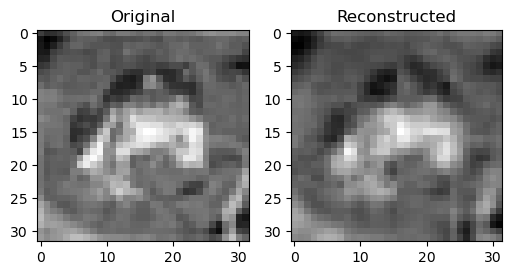

In [ ]:
# 흑백출력인데, GPU 좀더 효과적으로 사용
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# -----------------------------
# 1. GPU용 DCT/IDCT 함수 (Matrix Multiplication 방식)
# -----------------------------
# Scipy 대신 PyTorch 행렬 연산을 사용하여 GPU에서 직접 계산합니다.
def get_dct_matrix(n, device):
    """DCT 변환 행렬 C를 생성합니다."""
    matrix = torch.zeros((n, n), device=device)
    for i in range(n):
        for j in range(n):
            if i == 0:
                matrix[i, j] = 1 / math.sqrt(n)
            else:
                matrix[i, j] = math.sqrt(2 / n) * math.cos((math.pi * i * (2 * j + 1)) / (2 * n))
    return matrix

def dct2_gpu(x, dct_mat):
    """
    x: (Batch, 1, 8, 8) 
    formula: C * x * C^T
    """
    return torch.matmul(torch.matmul(dct_mat, x), dct_mat.t())

def idct2_gpu(x, dct_mat):
    """
    formula: C^T * x * C
    """
    return torch.matmul(torch.matmul(dct_mat.t(), x), dct_mat)

# -----------------------------
# 2. AutoEncoder (배치 처리에 최적화)
# -----------------------------
class DCTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        # x shape: (N, 64)
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# -----------------------------
# 3. 데이터 준비 및 설정
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 512  # 3090의 메모리를 활용하기 위해 크게 설정

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4) # num_workers로 데이터 로딩 가속

model = DCTAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# DCT 행렬 미리 계산 (8x8 용)
dct_mat = get_dct_matrix(8, device)

# -----------------------------
# 4. Training Loop (GPU 가속 버전)
# -----------------------------
epochs = 10
model.train()

print(f"학습 시작 (Device: {device})")
for epoch in range(epochs):
    total_loss = 0.0
    for imgs, _ in loader:
        # 1. 이미지를 GPU로 이동 (imgs shape: B, 1, 32, 32)
        imgs = imgs.to(device)
        B = imgs.shape[0]

        # 2. 이미지를 8x8 블록으로 쪼개기 (가장 중요한 가속 포인트)
        # (B, 1, 32, 32) -> (B, 1, 4, 8, 4, 8) -> (B, 16, 8, 8)
        blocks = imgs.unfold(2, 8, 8).unfold(3, 8, 8)
        blocks = blocks.contiguous().view(B, -1, 8, 8) # (Batch, 16개블록, 8, 8)
        
        # 3. GPU에서 배치로 DCT 수행
        dct_coeffs = dct2_gpu(blocks, dct_mat) # (B, 16, 8, 8)
        dct_input = dct_coeffs.view(-1, 64)   # (B*16, 64) 모델 입력을 위해 펼침

        # 4. 학습
        optimizer.zero_grad()
        recon = model(dct_input)
        loss = criterion(recon, dct_input)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(loader):.6f}")

# -----------------------------
# 5. 결과 확인 (첫 번째 배치 활용)
# -----------------------------
model.eval()
with torch.no_grad():
    sample_img, _ = dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device) # (1, 1, 32, 32)
    
    # 블록화 및 DCT
    b = sample_img.unfold(2, 8, 8).unfold(3, 8, 8).contiguous().view(1, 16, 8, 8)
    d = dct2_gpu(b, dct_mat).view(-1, 64)
    
    # 모델 통과 및 IDCT 복원
    r = model(d).view(1, 16, 8, 8)
    recon_img_tensor = idct2_gpu(r, dct_mat)
    
    # (1, 16, 8, 8) 블록을 다시 (32, 32) 이미지로 조립
    # 이 과정은 시각화를 위해 간단히 numpy로 처리하겠습니다.
    recon_img = torch.zeros((32, 32))
    idx = 0
    for i in range(0, 32, 8):
        for j in range(0, 32, 8):
            recon_img[i:i+8, j:j+8] = recon_img_tensor[0, idx]
            idx += 1

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(sample_img.cpu().squeeze(), cmap='gray'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(recon_img.numpy(), cmap='gray'); plt.title("Reconstructed")
plt.show()

Files already downloaded and verified
[Epoch 1] loss = 27.5767
[Epoch 2] loss = 1.7321
[Epoch 3] loss = 1.1238
[Epoch 4] loss = 0.8349
[Epoch 5] loss = 0.7050


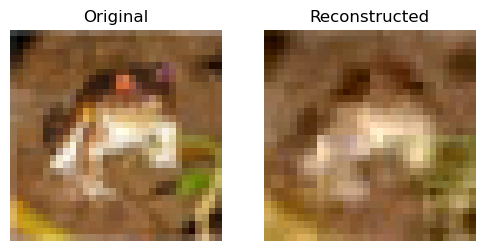

In [ ]:
# 컬러 출력
# dct_ae_cifar10_ycbcr_gpu.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.fftpack import dct, idct

# =========================================================
# 1. DCT / IDCT (block-wise)
# =========================================================

def dct2(block):
    return dct(dct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def idct2(block):
    return idct(idct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def image_to_dct_blocks_batch(imgs, block_size=8):
    """
    imgs: (B, H, W)
    return: (B, num_blocks, 64)
    """
    B, H, W = imgs.shape
    blocks = []

    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = imgs[:, i:i+block_size, j:j+block_size]
            block_dct = dct2(block)
            blocks.append(block_dct.reshape(B, -1))

    return np.stack(blocks, axis=1)  # (B, num_blocks, 64)

def dct_blocks_to_image(blocks, H, W, block_size=8):
    img = np.zeros((H, W))
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            img[i:i+block_size, j:j+block_size] = idct2(
                blocks[idx].reshape(block_size, block_size)
            )
            idx += 1
    return img

# =========================================================
# 2. RGB → YCbCr + 4:2:0 Transform
# =========================================================

class RGB2YCbCr420:
    def __call__(self, img: Image.Image):
        ycbcr = np.array(img.convert("YCbCr"), dtype=np.float32)

        Y  = ycbcr[:, :, 0] / 255.0
        Cb = ycbcr[:, :, 1]
        Cr = ycbcr[:, :, 2]

        Cb_ds = self.downsample(Cb) / 255.0
        Cr_ds = self.downsample(Cr) / 255.0

        return {
            "Y": torch.tensor(Y).unsqueeze(0),
            "Cb": torch.tensor(Cb_ds),
            "Cr": torch.tensor(Cr_ds),
        }

    def downsample(self, ch):
        return (
            ch[0::2, 0::2] +
            ch[1::2, 0::2] +
            ch[0::2, 1::2] +
            ch[1::2, 1::2]
        ) / 4.0

# =========================================================
# 3. DCT AutoEncoder
# =========================================================

class DCTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# =========================================================
# 4. Dataset / DataLoader
# =========================================================

transform = RGB2YCbCr420()

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,      # ★ GPU 사용률 핵심
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

# =========================================================
# 5. Training
# =========================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AE_Y = DCTAutoEncoder().to(device)
AE_C = DCTAutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    list(AE_Y.parameters()) + list(AE_C.parameters()),
    lr=1e-3
)

epochs = 5

for epoch in range(epochs):
    total_loss = 0.0

    for sample, _ in loader:
        Y  = sample["Y"].squeeze(1).numpy()     # (B, 32, 32)
        Cb = sample["Cb"].numpy()               # (B, 16, 16)
        Cr = sample["Cr"].numpy()

        dct_Y  = image_to_dct_blocks_batch(Y)
        dct_Cb = image_to_dct_blocks_batch(Cb)
        dct_Cr = image_to_dct_blocks_batch(Cr)

        # (B, blocks, 64) → (B*blocks, 64)
        dct_Y  = torch.tensor(dct_Y,  dtype=torch.float32).view(-1, 64).to(device)
        dct_Cb = torch.tensor(dct_Cb, dtype=torch.float32).view(-1, 64).to(device)
        dct_Cr = torch.tensor(dct_Cr, dtype=torch.float32).view(-1, 64).to(device)

        optimizer.zero_grad()

        rec_Y  = AE_Y(dct_Y)
        rec_Cb = AE_C(dct_Cb)
        rec_Cr = AE_C(dct_Cr)

        loss = (
            criterion(rec_Y, dct_Y)
            + 0.25 * (criterion(rec_Cb, dct_Cb) + criterion(rec_Cr, dct_Cr))
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] loss = {total_loss:.4f}")

# =========================================================
# 6. Visualization
# =========================================================

AE_Y.eval()
AE_C.eval()

with torch.no_grad():
    sample, _ = dataset[0]

    Y  = sample["Y"].squeeze().numpy()
    Cb = sample["Cb"].numpy()
    Cr = sample["Cr"].numpy()

    rec_Y  = dct_blocks_to_image(
        AE_Y(torch.tensor(image_to_dct_blocks_batch(Y[None])).view(-1,64).to(device)).cpu().numpy(),
        32, 32
    )
    rec_Cb = dct_blocks_to_image(
        AE_C(torch.tensor(image_to_dct_blocks_batch(Cb[None])).view(-1,64).to(device)).cpu().numpy(),
        16, 16
    )
    rec_Cr = dct_blocks_to_image(
        AE_C(torch.tensor(image_to_dct_blocks_batch(Cr[None])).view(-1,64).to(device)).cpu().numpy(),
        16, 16
    )

# 업샘플
rec_Cb = np.repeat(np.repeat(rec_Cb, 2, axis=0), 2, axis=1)
rec_Cr = np.repeat(np.repeat(rec_Cr, 2, axis=0), 2, axis=1)

# YCbCr → RGB
R = rec_Y + 1.402 * (rec_Cr - 0.5)
G = rec_Y - 0.344136 * (rec_Cb - 0.5) - 0.714136 * (rec_Cr - 0.5)
B = rec_Y + 1.772 * (rec_Cb - 0.5)

rgb_rec = np.clip(np.stack([R, G, B], axis=2), 0, 1)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(np.array(dataset.data[0]) / 255.0)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(rgb_rec)
plt.axis("off")
plt.show()


In [ ]:
# dct_ae_cifar10_ycbcr_final.py
# YCbCr + DCT + AutoEncoder 기반 학습 압축 (최종본)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.fftpack import dct, idct

# =========================================================
# 1. DCT / IDCT utilities
# =========================================================

def dct2(block):
    return dct(dct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def idct2(block):
    return idct(idct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def image_to_dct_blocks_batch(imgs, block_size=8):
    """
    imgs: (B, H, W)
    return: (B, num_blocks, 64)
    """
    B, H, W = imgs.shape
    blocks = []

    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = imgs[:, i:i+block_size, j:j+block_size]
            block_dct = dct2(block)
            blocks.append(block_dct.reshape(B, -1))

    return np.stack(blocks, axis=1)

def dct_blocks_to_image(blocks, H, W, block_size=8):
    img = np.zeros((H, W))
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            img[i:i+block_size, j:j+block_size] = idct2(
                blocks[idx].reshape(block_size, block_size)
            )
            idx += 1
    return img

# =========================================================
# 2. RGB → YCbCr + 4:2:0 Transform
# =========================================================

class RGB2YCbCr420:
    def __call__(self, img: Image.Image):
        ycbcr = np.array(img.convert("YCbCr"), dtype=np.float32)

        Y  = ycbcr[:, :, 0] / 255.0
        Cb = ycbcr[:, :, 1]
        Cr = ycbcr[:, :, 2]

        Cb_ds = self.downsample(Cb) / 255.0
        Cr_ds = self.downsample(Cr) / 255.0

        return {
            "Y":  torch.tensor(Y).unsqueeze(0),   # (1,32,32)
            "Cb": torch.tensor(Cb_ds),            # (16,16)
            "Cr": torch.tensor(Cr_ds),            # (16,16)
        }

    def downsample(self, ch):
        return (
            ch[0::2, 0::2] +
            ch[1::2, 0::2] +
            ch[0::2, 1::2] +
            ch[1::2, 1::2]
        ) / 4.0

# =========================================================
# 3. Parametric DCT AutoEncoder
# =========================================================

class DCTAutoEncoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims):
        super().__init__()

        enc = []
        in_dim = 64
        for h in hidden_dims:
            enc += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        enc += [nn.Linear(in_dim, latent_dim)]
        self.encoder = nn.Sequential(*enc)

        dec = []
        in_dim = latent_dim
        for h in reversed(hidden_dims):
            dec += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        dec += [nn.Linear(in_dim, 64)]
        self.decoder = nn.Sequential(*dec)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# =========================================================
# 4. Dataset / DataLoader
# =========================================================

transform = RGB2YCbCr420()

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,      # Colab 안정적
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# =========================================================
# 5. Training
# =========================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AE_Y = DCTAutoEncoder(
    latent_dim=16,
    hidden_dims=[48, 32]
).to(device)

AE_C = DCTAutoEncoder(
    latent_dim=4,
    hidden_dims=[16]
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    list(AE_Y.parameters()) + list(AE_C.parameters()),
    lr=3e-4
)

epochs = 150

print("=== Compression Ratio ===")
orig_size = 32 * 32 * 3
latent_size = 16*16 + 4*4 + 4*4
print(f"Original size: {orig_size}")
print(f"Latent size:   {latent_size}")
print(f"Compression ratio: {orig_size / latent_size:.2f}:1\n")

for epoch in range(epochs):
    total_loss = 0.0

    for sample, _ in loader:
        Y  = sample["Y"].squeeze(1).numpy()   # (B,32,32)
        Cb = sample["Cb"].numpy()             # (B,16,16)
        Cr = sample["Cr"].numpy()

        dct_Y  = image_to_dct_blocks_batch(Y)
        dct_Cb = image_to_dct_blocks_batch(Cb)
        dct_Cr = image_to_dct_blocks_batch(Cr)

        dct_Y  = torch.tensor(dct_Y,  dtype=torch.float32).view(-1,64).to(device)
        dct_Cb = torch.tensor(dct_Cb, dtype=torch.float32).view(-1,64).to(device)
        dct_Cr = torch.tensor(dct_Cr, dtype=torch.float32).view(-1,64).to(device)

        optimizer.zero_grad()

        rec_Y  = AE_Y(dct_Y)
        rec_Cb = AE_C(dct_Cb)
        rec_Cr = AE_C(dct_Cr)

        loss_Y  = criterion(rec_Y, dct_Y)
        loss_Cb = criterion(rec_Cb, dct_Cb)
        loss_Cr = criterion(rec_Cr, dct_Cr)

        loss = loss_Y + 0.25 * (loss_Cb + loss_Cr)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1:3d}] total loss = {total_loss:.4f}")

# =========================================================
# 6. Visualization
# =========================================================

AE_Y.eval()
AE_C.eval()

with torch.no_grad():
    sample, _ = dataset[0]

    Y  = sample["Y"].squeeze().numpy()
    Cb = sample["Cb"].numpy()
    Cr = sample["Cr"].numpy()

    rec_Y  = dct_blocks_to_image(
        AE_Y(torch.tensor(image_to_dct_blocks_batch(Y[None])).view(-1,64).to(device)).cpu().numpy(),
        32, 32
    )
    rec_Cb = dct_blocks_to_image(
        AE_C(torch.tensor(image_to_dct_blocks_batch(Cb[None])).view(-1,64).to(device)).cpu().numpy(),
        16, 16
    )
    rec_Cr = dct_blocks_to_image(
        AE_C(torch.tensor(image_to_dct_blocks_batch(Cr[None])).view(-1,64).to(device)).cpu().numpy(),
        16, 16
    )

# 업샘플 (nearest)
rec_Cb = np.repeat(np.repeat(rec_Cb, 2, axis=0), 2, axis=1)
rec_Cr = np.repeat(np.repeat(rec_Cr, 2, axis=0), 2, axis=1)

# YCbCr → RGB
R = rec_Y + 1.402 * (rec_Cr - 0.5)
G = rec_Y - 0.344136 * (rec_Cb - 0.5) - 0.714136 * (rec_Cr - 0.5)
B = rec_Y + 1.772 * (rec_Cb - 0.5)

rgb_rec = np.clip(np.stack([R, G, B], axis=2), 0, 1)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(np.array(dataset.data[0]) / 255.0)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(rgb_rec)
plt.axis("off")
plt.show()


In [ ]:
# 중간에 DCT랑 이미지 출력

# dct_ae_cifar10_ycbcr_with_dct_visualization.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.fftpack import dct, idct

# =========================================================
# 1. DCT / IDCT utilities
# =========================================================

def dct2(block):
    return dct(dct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def idct2(block):
    return idct(idct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def image_to_dct_blocks_batch(imgs, block_size=8):
    B, H, W = imgs.shape
    blocks = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = imgs[:, i:i+block_size, j:j+block_size]
            block_dct = dct2(block)
            blocks.append(block_dct.reshape(B, -1))
    return np.stack(blocks, axis=1)

def dct_blocks_to_image(blocks, H, W, block_size=8):
    img = np.zeros((H, W))
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            img[i:i+block_size, j:j+block_size] = idct2(
                blocks[idx].reshape(block_size, block_size)
            )
            idx += 1
    return img

# =========================================================
# 2. RGB → YCbCr + 4:2:0 Transform
# =========================================================

class RGB2YCbCr420:
    def __call__(self, img: Image.Image):
        ycbcr = np.array(img.convert("YCbCr"), dtype=np.float32)

        Y  = ycbcr[:, :, 0] / 255.0
        Cb = ycbcr[:, :, 1]
        Cr = ycbcr[:, :, 2]

        Cb_ds = self.downsample(Cb) / 255.0
        Cr_ds = self.downsample(Cr) / 255.0

        return {
            "Y":  torch.tensor(Y).unsqueeze(0),
            "Cb": torch.tensor(Cb_ds),
            "Cr": torch.tensor(Cr_ds),
        }

    def downsample(self, ch):
        return (
            ch[0::2, 0::2] +
            ch[1::2, 0::2] +
            ch[0::2, 1::2] +
            ch[1::2, 1::2]
        ) / 4.0

# =========================================================
# 3. Parametric DCT AutoEncoder
# =========================================================

class DCTAutoEncoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims):
        super().__init__()

        enc = []
        in_dim = 64
        for h in hidden_dims:
            enc += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        enc += [nn.Linear(in_dim, latent_dim)]
        self.encoder = nn.Sequential(*enc)

        dec = []
        in_dim = latent_dim
        for h in reversed(hidden_dims):
            dec += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        dec += [nn.Linear(in_dim, 64)]
        self.decoder = nn.Sequential(*dec)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# =========================================================
# 4. Dataset / DataLoader
# =========================================================

transform = RGB2YCbCr420()

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# =========================================================
# 5. Training setup
# =========================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AE_Y = DCTAutoEncoder(latent_dim=16, hidden_dims=[48, 32]).to(device)
AE_C = DCTAutoEncoder(latent_dim=4,  hidden_dims=[16]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    list(AE_Y.parameters()) + list(AE_C.parameters()),
    lr=3e-4
)

epochs = 100
vis_epochs = [10, 50, 100]

# 고정 시각화용 샘플
fixed_sample, _ = dataset[0]
fixed_Y  = fixed_sample["Y"].squeeze().numpy()
fixed_Cb = fixed_sample["Cb"].numpy()
fixed_Cr = fixed_sample["Cr"].numpy()

# =========================================================
# 6. Training + Visualization
# =========================================================

for epoch in range(epochs):
    total_loss = 0.0

    for sample, _ in loader:
        Y  = sample["Y"].squeeze(1).numpy()
        Cb = sample["Cb"].numpy()
        Cr = sample["Cr"].numpy()

        dct_Y  = torch.tensor(
            image_to_dct_blocks_batch(Y),
            dtype=torch.float32
        ).view(-1,64).to(device)

        dct_Cb = torch.tensor(
            image_to_dct_blocks_batch(Cb),
            dtype=torch.float32
        ).view(-1,64).to(device)

        dct_Cr = torch.tensor(
            image_to_dct_blocks_batch(Cr),
            dtype=torch.float32
        ).view(-1,64).to(device)

        optimizer.zero_grad()

        rec_Y  = AE_Y(dct_Y)
        rec_Cb = AE_C(dct_Cb)
        rec_Cr = AE_C(dct_Cr)

        loss = (
            criterion(rec_Y, dct_Y)
            + 0.25 * (criterion(rec_Cb, dct_Cb) + criterion(rec_Cr, dct_Cr))
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1:3d}] loss = {total_loss:.4f}")

    # =====================================================
    # Visualization at selected epochs
    # =====================================================

    if (epoch+1) in vis_epochs:
        AE_Y.eval()
        AE_C.eval()

        with torch.no_grad():
            dct_Y_fixed = image_to_dct_blocks_batch(fixed_Y[None])[0]

            rec_Y_img = dct_blocks_to_image(
                AE_Y(
                    torch.tensor(dct_Y_fixed, dtype=torch.float32)
                    .to(device)
                ).cpu().numpy(),
                32, 32
            )

            rec_Cb_img = dct_blocks_to_image(
                AE_C(
                    torch.tensor(
                        image_to_dct_blocks_batch(fixed_Cb[None])[0],
                        dtype=torch.float32
                    ).to(device)
                ).cpu().numpy(),
                16, 16
            )

            rec_Cr_img = dct_blocks_to_image(
                AE_C(
                    torch.tensor(
                        image_to_dct_blocks_batch(fixed_Cr[None])[0],
                        dtype=torch.float32
                    ).to(device)
                ).cpu().numpy(),
                16, 16
            )

        # 업샘플
        rec_Cb_img = np.repeat(np.repeat(rec_Cb_img, 2, axis=0), 2, axis=1)
        rec_Cr_img = np.repeat(np.repeat(rec_Cr_img, 2, axis=0), 2, axis=1)

        # YCbCr → RGB
        R = rec_Y_img + 1.402 * (rec_Cr_img - 0.5)
        G = rec_Y_img - 0.344136 * (rec_Cb_img - 0.5) - 0.714136 * (rec_Cr_img - 0.5)
        B = rec_Y_img + 1.772 * (rec_Cb_img - 0.5)
        rgb_rec = np.clip(np.stack([R, G, B], axis=2), 0, 1)

        # DCT 시각화 (첫 번째 블록)
        dct_block = dct_Y_fixed[0].reshape(8,8)
        dct_vis = np.log(np.abs(dct_block) + 1e-6)

        plt.figure(figsize=(9,3))
        plt.suptitle(f"Epoch {epoch+1}", fontsize=14)

        plt.subplot(1,3,1)
        plt.title("Y DCT (log-scale)")
        plt.imshow(dct_vis, cmap="gray")
        plt.colorbar()
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Reconstructed Y")
        plt.imshow(rec_Y_img, cmap="gray")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Reconstructed RGB")
        plt.imshow(rgb_rec)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        AE_Y.train()
        AE_C.train()


In [ ]:
# dct_ae_dct_before_decoder_visualization.py
# Decoder 출력 DCT 변화 시각화 (epoch=50)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct

# =========================================================
# DCT / IDCT
# =========================================================

def dct2(block):
    return dct(dct(block, axis=-2, norm='ortho'), axis=-1, norm='ortho')

def image_to_dct_blocks(img, block_size=8):
    H, W = img.shape
    blocks = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = img[i:i+block_size, j:j+block_size]
            blocks.append(dct2(block).flatten())
    return np.stack(blocks)

# =========================================================
# RGB → YCbCr (Y only)
# =========================================================

class RGB2Y:
    def __call__(self, img: Image.Image):
        y = np.array(img.convert("YCbCr"), dtype=np.float32)[:,:,0] / 255.0
        return torch.tensor(y).unsqueeze(0)

# =========================================================
# DCT AutoEncoder
# =========================================================

class DCTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# =========================================================
# Dataset
# =========================================================

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=RGB2Y()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DCTAutoEncoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 고정 이미지
fixed_img, _ = dataset[0]
fixed_img = fixed_img.squeeze().numpy()
fixed_dct = image_to_dct_blocks(fixed_img)
fixed_block = fixed_dct[0]   # 첫 번째 8×8 블록

# =========================================================
# Training + DCT tracking
# =========================================================

epochs = 50
checkpoints = [1, 10, 25, 50]
dct_history = {}

for epoch in range(epochs):
    model.train()

    for img, _ in dataset:
        img = img.squeeze().numpy()
        dct_blocks = image_to_dct_blocks(img)
        dct_blocks = torch.tensor(dct_blocks, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        recon = model(dct_blocks)
        loss = criterion(recon, dct_blocks)
        loss.backward()
        optimizer.step()

    # DCT 변화 저장
    if (epoch+1) in checkpoints:
        model.eval()
        with torch.no_grad():
            dct_in = torch.tensor(fixed_block, dtype=torch.float32).to(device)
            dct_out = model(dct_in.unsqueeze(0)).cpu().numpy()[0]
            dct_history[epoch+1] = dct_out

    print(f"[Epoch {epoch+1:2d}] done")

# =========================================================
# Visualization
# =========================================================

plt.figure(figsize=(12, 3*len(checkpoints)))

for i, ep in enumerate(checkpoints):
    dct_out = dct_history[ep]

    dct_in_img  = np.log(np.abs(fixed_block.reshape(8,8)) + 1e-6)
    dct_out_img = np.log(np.abs(dct_out.reshape(8,8)) + 1e-6)
    dct_diff    = np.log(np.abs(dct_out - fixed_block).reshape(8,8) + 1e-6)

    plt.subplot(len(checkpoints), 3, 3*i+1)
    plt.title(f"Epoch {ep} | Input DCT")
    plt.imshow(dct_in_img, cmap="gray")
    plt.axis("off")

    plt.subplot(len(checkpoints), 3, 3*i+2)
    plt.title("Reconstructed DCT")
    plt.imshow(dct_out_img, cmap="gray")
    plt.axis("off")

    plt.subplot(len(checkpoints), 3, 3*i+3)
    plt.title("|DCT_out - DCT_in|")
    plt.imshow(dct_diff, cmap="hot")
    plt.axis("off")

plt.tight_layout()
plt.show()
